<a href="https://colab.research.google.com/github/1900690/grape-sky-segmentation/blob/main/grape-sky-binarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#画像から特定のピクセルで色を分ける
参考：[UAV による農作物の判別と生育状況把握](https://www.tuis.ac.jp/media/R1_J5_3.pdf)

参考：[デジタルカメラと画像処理ソフト「Fiji-ImageJ」を用いたブドウの葉面積指数の簡易推定技術](https://www.naro.go.jp/laboratory/karc/prefectural_results/files/R02_4_04.pdf)



Saving cut-grape-LAI22.jpg to cut-grape-LAI22 (1).jpg


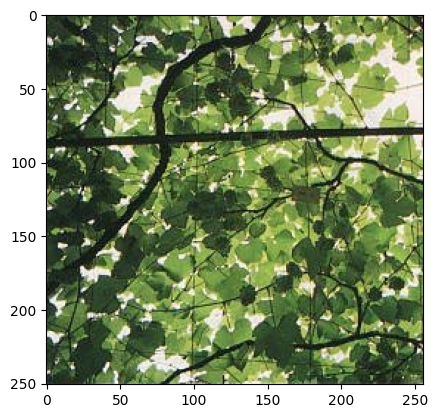

In [71]:
#@title 表示する画像をアップロード
from google.colab import files
uploaded_file = files.upload()
uploaded_file_name = next(iter(uploaded_file))

#読み込んだ画像を表示
#・OpenCVを使って画像を読み込む cv2.imreadでOpenCV形式に変換 OpenCVはBGRなのでcvtColorでRGBに直してから表示する
import cv2
from matplotlib import pyplot as plt
orig = cv2.imread(uploaded_file_name)
src = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
plt.imshow(src)

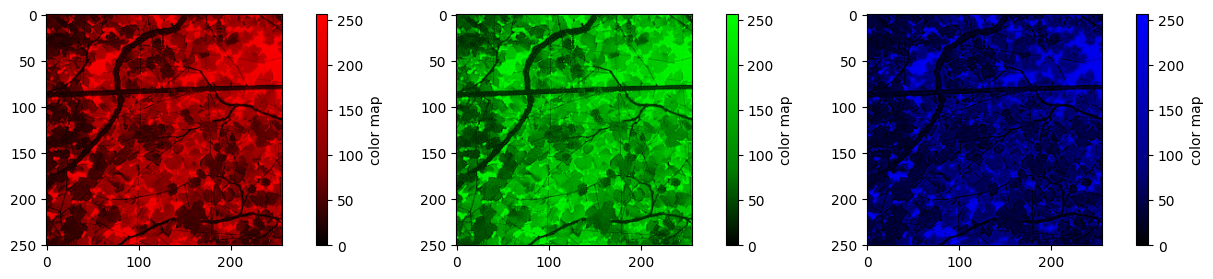

In [72]:
#@title RGBに分けた画像を表示
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

#カラーマップ作製
#赤
r1 = np.array([0,0,0]) / 256
r2 = np.array([128,0,0]) / 256
r3 = np.array([192,0,0]) / 256
r4 = np.array([256,0,0]) / 256
cmr = LinearSegmentedColormap.from_list(name='customred', colors=[r1, r2, r3, r4])
#緑
g1 = np.array([0,0,0]) / 256
g2 = np.array([0,128,0]) / 256
g3 = np.array([0,192,0]) / 256
g4 = np.array([0,256, 0]) / 256
cmg = LinearSegmentedColormap.from_list(name='customgreen', colors=[g1, g2, g3, g4])
#青
b1 = np.array([0,0,0]) / 256
b2 = np.array([0,0,128]) / 256
b3 = np.array([0,0,192]) / 256
b4 = np.array([0,0,256]) / 256
cmb = LinearSegmentedColormap.from_list(name='customblue', colors=[b1, b2, b3, b4])

#色の指定の最小値、最大値
vmin,vmax = 0, 256

r = np.array(src[:, :, 0], dtype=np.int16)
g = np.array(src[:, :, 1], dtype=np.int16)
b = np.array(src[:, :, 2], dtype=np.int16)

#図を表示
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.imshow(r,cmap = cmr, vmin=vmin, vmax=vmax)
plt.colorbar( label = 'color map', pad = 0.1)
plt.subplot(1,3,2)
plt.imshow(g,cmap = cmg, vmin=vmin, vmax=vmax)
plt.colorbar( label = 'color map', pad = 0.1)
plt.subplot(1,3,3)
plt.imshow(b,cmap = cmb, vmin=vmin, vmax=vmax)
plt.colorbar( label = 'color map', pad = 0.1)

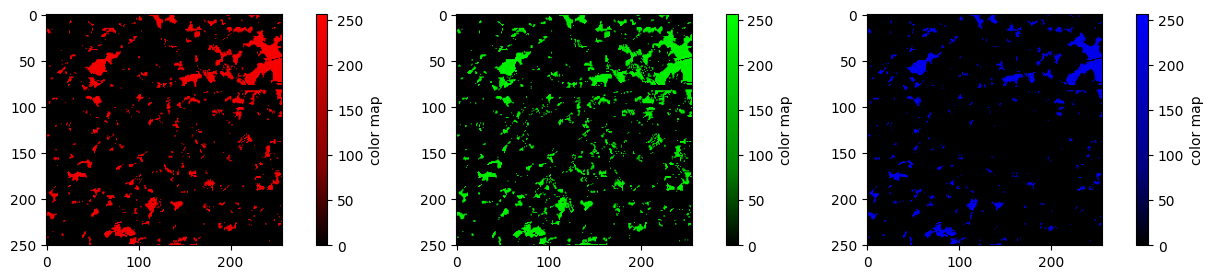

In [74]:
#@title 各色の二値化の基準を決め各色のマスクを作成
#@markdown 赤の閾値
Rmax = 255 # @param {type:"slider", min:0, max:255, step:1}
Rmin = 200 # @param {type:"slider", min:0, max:255, step:1}
#@markdown 緑の閾値
Gmax = 255 # @param {type:"slider", min:0, max:255, step:1}
Gmin = 200 # @param {type:"slider", min:0, max:255, step:1}
#@markdown 青の閾値
Bmax = 255 # @param {type:"slider", min:0, max:255, step:1}
Bmin = 200 # @param {type:"slider", min:0, max:255, step:1}


r_temp=np.where(r < Rmin, 0, r)
r_mask=np.where(r_temp > Rmax, 0, r_temp)

g_temp=np.where(g < Gmin, 0, g)
g_mask=np.where(g_temp > Gmax, 0, g_temp)

b_temp=np.where(b < Bmin, 0, b)
b_mask=np.where(b_temp > Bmax, 0, b_temp)

#図を表示
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.imshow(r_mask,cmap = cmr, vmin=vmin, vmax=vmax)
plt.colorbar( label = 'color map', pad = 0.1)
plt.subplot(1,3,2)
plt.imshow(g_mask,cmap = cmg, vmin=vmin, vmax=vmax)
plt.colorbar( label = 'color map', pad = 0.1)
plt.subplot(1,3,3)
plt.imshow(b_mask,cmap = cmb, vmin=vmin, vmax=vmax)
plt.colorbar( label = 'color map', pad = 0.1)

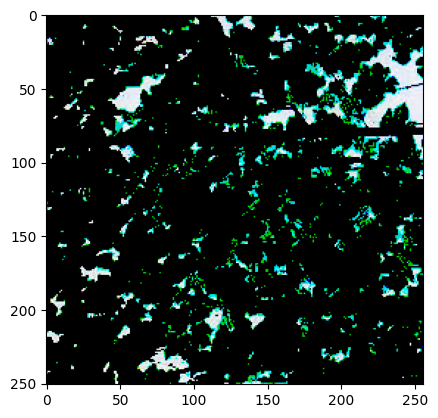

In [76]:
#@title 分けた画像を合成
binde_image=np.empty_like(src)
binde_image[:,:,0]=r_mask
binde_image[:,:,1]=g_mask
binde_image[:,:,2]=b_mask

src2 = cv2.cvtColor(binde_image, cv2.COLOR_BGR2RGB)
plt.imshow(src2)

空の占める割合は 12 %


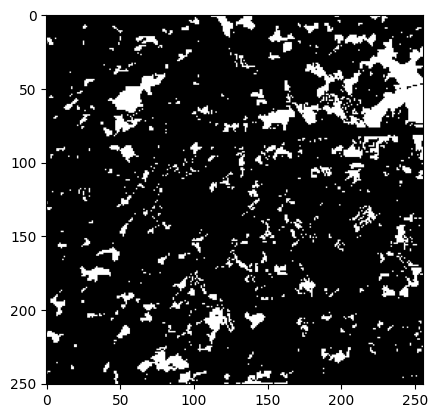

In [77]:
#@title 白黒に変換し、画面の中の白の割合を計算
import math

binde_image_binary=r_mask+g_mask+b_mask
binde_image_binary=np.where(binde_image_binary > 0, 1, binde_image_binary)

plt.imshow(binde_image_binary, cmap='gray')

all_pixcel=binde_image_binary.shape[0]*binde_image_binary.shape[1]
sky_pixcel=np.sum(binde_image_binary)

sky_occupancy_rate=sky_pixcel/all_pixcel
print("空の占める割合は",math.floor(sky_occupancy_rate*100),"%")

In [78]:
#@title マスク画像をダウンロード
from PIL import Image

#@markdown マスク画像の色をRGBで指定する
Routput = 255 # @param {type:"slider", min:0, max:255, step:1}
Goutput = 255 # @param {type:"slider", min:0, max:255, step:1}
Boutput = 255 # @param {type:"slider", min:0, max:255, step:1}


binde_image_output=np.empty_like(src)
binde_image_output[:,:,0]=np.where(binde_image_binary > 0, Routput, 0)
binde_image_output[:,:,1]=np.where(binde_image_binary > 0, Goutput, 0)
binde_image_output[:,:,2]=np.where(binde_image_binary > 0, Boutput, 0)

pil_img = Image.fromarray(binde_image_output)
pil_img.save('/content/binary_'+uploaded_file_name)

files.download('/content/binary_'+uploaded_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>